## Text Summarization
Customer reviews can often be long and descriptive. Analyzing these reviews manually, as you can imagine, is really time-consuming. This is where the brilliance of Natural Language Processing can be applied to generate a summary for long reviews.
We will be working on a really cool dataset. Our objective here is to generate a summary for the Amazon Fine Food reviews using the abstraction-based approach we learned about above.

https://www.kaggle.com/snap/amazon-fine-food-reviews


In [3]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import keras
import transformers
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
#from keras.preprocessing.text import Tokenizer
#from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from txtai.pipeline import Summary
from rouge_score import rouge_scorer
import nltk
nltk.download('stopwords')
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('Reviews.csv',nrows=100)

In [5]:
df.shape

(100, 10)

In [6]:
df[['Summary','Text']].head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [7]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [8]:
df.dropna(axis=0, inplace=True)

In [9]:
df.drop_duplicates(subset=['Text'], inplace=True)  # dropping duplicates


In [10]:
df.shape

(99, 10)

## Preprocessing
Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

We will perform the below preprocessing tasks for our data:

- Convert everything to lowercase
- Remove HTML tags
- Contraction mapping
- Remove (‘s)
- Remove any text inside the parenthesis ( )
- Eliminate punctuations and special characters
- Remove stopwords
- Remove short words

In [11]:
contractions_dict = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have",
}


In [12]:
stop_words = set(stopwords.words('english'))


def text_cleaner(text):
    '''
    clean text column in dataset
    '''
    newString = text.lower() # lowercase words
    newString = BeautifulSoup(newString, "lxml").text # remove HTML tags , pip install lxml
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"', '', newString) # remove quotes
    newString = ' '.join([contractions_dict[t] if t in contractions_dict else t for t in newString.split(" ")]) # the dictionary that we will use for expanding the contractions
    newString = re.sub(r"'s\b", "", newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) # match all strings that contain a non-letter
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words = []
    for i in tokens:
        if len(i) >= 3:  # removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip() # remove the whitespaces or specific characters from the string at the beginning and end of the string


cleaned_text = []
for t in df['Text']:
    cleaned_text.append(text_cleaner(t))

In [13]:
df['Summary'][:10]


0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [14]:
def summary_cleaner(text):
    '''
    clean summary column in dataset
    '''
    newString = re.sub('"', '', str(text))  # remove quotes
    newString = ' '.join([contractions_dict[t] if t in contractions_dict else t for t in newString.split(" ")])  # the dictionary that we will use for expanding the contractions
    newString = re.sub(r"'s\b", "", newString)
    # match all strings that contain a non-letter
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()  # lowercase words
    tokens = newString.split()
    newString = ''
    for i in tokens:
        if len(i) > 1:
            newString = newString+i+' '
    return newString


cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [15]:
# create new colums 'cleaned_text' and 'cleaned_summary'
df['cleaned_text'] = cleaned_text
df['cleaned_summary'] = cleaned_summary
df['cleaned_summary'].replace('', np.nan, inplace=True) # empty values with nan
df.dropna(axis=0, inplace=True)

In [16]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,cleaned_summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...",confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,delight says it all
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy


# Abstractive Summarization


Abstractive summarization is a text summarization technique that generates a concise summary by creating new sentences that convey the main ideas of the original text. Unlike extractive summarization, which directly selects sentences or phrases from the source text, abstractive methods aim to produce summaries that are closer to how a human might summarize, often rephrasing or synthesizing information.
Some of its key features are:

- **Generative Approach:** Abstractive summarization involves generating new text that captures the essence of the input while using different phrasing and sentence structures.

- **Contextual Understanding:** Advanced models analyze the text to understand its overall meaning and produce coherent summaries.

- **Flexibility:** This method allows for the integration of knowledge, inference, and rephrasing, making it suitable for summarizing complex and varied content.

# part 1

Go here: https://huggingface.co/models?pipeline_tag=summarization and chose any model you want, by default it will use a distilbart

### we will import and test 3 diiferents model here and compare them
- summary1 = Summary('facebook/bart-large-cnn')
- summary2 = Summary('Falconsai/text_summarization')
- summary3 = Summary('SEBIS/code_trans_t5_small_code_documentation_generation_php_multitask_finetune')

In [17]:
summary1 = Summary('facebook/bart-large-cnn')

Device set to use cpu


In [18]:
df.shape

(99, 12)

In [19]:
def predict_summary1(text, max_length=10):
    return summary1(text, maxlength=max_length)

# Apply summarization to all rows
df["predicted_summary1"] = df["cleaned_text"].apply(predict_summary1)

Your max_length is set to 10, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)
Your max_length is set to 10, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


In [20]:
summary2 = Summary('Falconsai/text_summarization')

Device set to use cpu


In [22]:
def predict_summary2(text, max_length=10):
    return summary2(text, maxlength=max_length)

# Apply summarization to all rows
df["predicted_summary2"] = df["cleaned_text"].apply(predict_summary2)

Your max_length is set to 10, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


In [23]:
summary3 = Summary('SEBIS/code_trans_t5_small_code_documentation_generation_php_multitask_finetune')

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cpu


In [24]:
def predict_summary3(text, max_length=10):
    return summary3(text, maxlength=max_length)

# Apply summarization to all rows
df["predicted_summary3"] = df["cleaned_text"].apply(predict_summary3)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [26]:
df[['cleaned_text','cleaned_summary','predicted_summary1','predicted_summary2','predicted_summary3']].head()

,cleaned_text,cleaned_summary,predicted_summary1,predicted_summary2,predicted_summary3
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food,Good quality product looks like stew processed,bought several vitality canned dog food products found,This method is used to make sure that the
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised,product arrived labeled jumbo salted,product arrived labeled jumbo sal,Produce a jumbo salted peanuts
2,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,delight says it all,Crisp citrus gelatin nuts case,confection around centuries light pillowy citrus gelatin,Perfoms a cookbook with a
3,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine,root beer extract ordered made cherry soda,looking secret ingredient robitussin believe,Get the root beer extract ordered by Drup
4,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy,Great taffy great price wide,great taffy great price wide assortment,yummy taffy yummy taff


## Evaluation 

as we can see from dataset above the first model (facebook/bart-large-cnn) seems to have beter prediction.

In [27]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


# Initialize ROUGE scorer
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smooth = SmoothingFunction()

# Function to calculate ROUGE and BLEU scores
def evaluate_summaries(row, col):
    reference = row["cleaned_summary"]
    prediction = row[col]
    
    # Calculate ROUGE scores
    rouge_scores = rouge_scorer.score(reference, prediction)
    
    # Calculate BLEU score
    reference_tokens = [reference.split()]
    prediction_tokens = prediction.split()
    bleu_score = sentence_bleu(reference_tokens, prediction_tokens, smoothing_function=smooth.method1)
    
    # Extract ROUGE scores as a dictionary and add BLEU
    return {
        "rouge1": rouge_scores["rouge1"].fmeasure,
        "rouge2": rouge_scores["rouge2"].fmeasure,
        "rougeL": rouge_scores["rougeL"].fmeasure,
        "bleu": bleu_score
    }

# Evaluate all models
for i in range(1, 4):  # Assuming 3 models
    col_name = f"predicted_summary{i}"
    df[f"evaluation_{col_name}"] = df.apply(lambda row: evaluate_summaries(row, col_name), axis=1)

# Aggregate scores
model_scores = {}
for i in range(1, 4):
    col_name = f"evaluation_predicted_summary{i}"
    scores_df = pd.DataFrame(df[col_name].tolist())  # Convert list of dicts to DataFrame
    avg_scores = scores_df.mean()  # Calculate average scores
    model_scores[f"model_{i}"] = avg_scores

# Display results
for model, scores in model_scores.items():
    print(f"Average scores for {model}:")
    print(scores)
    print()


Average scores for model_1:
rouge1    0.166179
rouge2    0.055220
rougeL    0.159773
bleu      0.025385
dtype: float64

Average scores for model_2:
rouge1    0.155571
rouge2    0.045459
rougeL    0.151898
bleu      0.024677
dtype: float64

Average scores for model_3:
rouge1    0.103786
rouge2    0.007560
rougeL    0.096990
bleu      0.017152
dtype: float64



## Observations:
- Model 1 performs best: It has the highest scores across all metrics, albeit still low.
- Model 2 is slightly worse: Its scores are close to Model 1 but slightly lower.
- Model 3 performs the worst: It has significantly lower scores, particularly for ROUGE-2 and BLEU.

### Metric Breakdown
- ROUGE-1: Measures the overlap of unigrams (single words) between the generated summary and the reference. It is a basic measure of how much content from the reference is captured.

Interpretation: Higher is better. Low scores suggest the generated summaries capture little overlap with the reference summaries.
- ROUGE-2: Measures the overlap of bigrams (pairs of consecutive words). It evaluates fluency and coherence.

Interpretation: Higher is better. Low scores here suggest the generated summaries lack alignment with the reference's phrase structures.
- ROUGE-L: Measures the longest common subsequence between the reference and generated summary. It reflects sentence-level structure retention.

Interpretation: Higher is better. Low scores indicate that the generated summaries fail to retain important sequential information.
- BLEU: Measures how many n-grams (e.g., words or phrases of different lengths) in the generated summary match the reference, with a penalty for overly short outputs.

Interpretation: Higher is better. Low BLEU scores indicate a poor match between the generated and reference summaries.

# part 2

## Text Summarizer using deep learning



## Note:
this types of analysis usually should be done by GPUs and very powerful memory system. 
as we have done it by regular cpu for only a small group of dataset (1000 rows) and only (epochs=20) here , the final result is not perfect. but the procedure is valuable.

### add the START and END special tokens at the beginning and end of the summary for the decoder


In [28]:
df['cleaned_summary'] = df['cleaned_summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [29]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,cleaned_summary,predicted_summary1,predicted_summary2,predicted_summary3,evaluation_predicted_summary1,evaluation_predicted_summary2,evaluation_predicted_summary3
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok,Good quality product looks like stew processed,bought several vitality canned dog food products found,This method is used to make sure that the,"{'rouge1': 0.36363636363636365, 'rouge2': 0.2222222222222222, 'rougeL': 0.36363636363636365, 'bleu': 0.033031643180138064}","{'rouge1': 0.3333333333333333, 'rouge2': 0.2, 'rougeL': 0.3333333333333333, 'bleu': 0.05873949094699214}","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'bleu': 0}"
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok,product arrived labeled jumbo salted,product arrived labeled jumbo sal,Produce a jumbo salted peanuts,"{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'bleu': 0}","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'bleu': 0}","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'bleu': 0}"
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...",confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,sostok delight says it all eostok,Crisp citrus gelatin nuts case,confection around centuries light pillowy citrus gelatin,Perfoms a cookbook with a,"{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'bleu': 0}","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'bleu': 0}","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'bleu': 0}"
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sostok cough medicine eostok,root beer extract ordered made cherry soda,looking secret ingredient robitussin believe,Get the root beer extract ordered by Drup,"{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'bleu': 0}","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'bleu': 0}","{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'bleu': 0}"
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sostok great taffy eostok,Great taffy great price wide,great taffy great price wide assortment,yummy taffy yummy taff,"{'rouge1': 0.5714285714285715, 'rouge2': 0.4, 'rougeL': 0.5714285714285715, 'bleu': 0.06389431042462

In [30]:
for i in range(5):
    print("Review:", df['cleaned_text'][i])
    print("Summary:", df['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: sostok good quality dog food  eostok


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: sostok not as advertised  eostok


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: sostok delight says it all  eostok


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: sostok cough medicine  eostok


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

## Understanding the distribution of the sequences
Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text.

This will help us fix the maximum length of the sequence

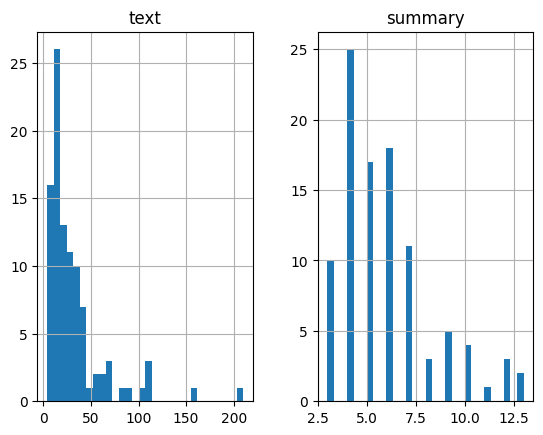

In [31]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [32]:
# We can fix the maximum length of the reviews to 80 since that seems to be the majority review length. Similarly, we can set the maximum summary length to 10
max_len_text = 80 
max_len_summary = 10

We are getting closer to the model building part. Before that, we need to split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10%



In [33]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(df['cleaned_text'], df['cleaned_summary'], test_size=0.1, random_state=0, shuffle=True)

### Preparing the Tokenizer
A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Go ahead and build tokenizers for text and summary

a) Text Tokenizer



In [34]:
# prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

# convert text sequences into integer sequences
x_tr = x_tokenizer.texts_to_sequences(x_tr)
x_val = x_tokenizer.texts_to_sequences(x_val)

# padding zero upto maximum length
x_tr = pad_sequences(x_tr,  maxlen=max_len_text, padding='post')
x_val = pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size = len(x_tokenizer.word_index) + 1

b) Summary Tokenizer



In [35]:
# preparing a tokenizer for summary on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

# convert summary sequences into integer sequences
y_tr = y_tokenizer.texts_to_sequences(y_tr)
y_val = y_tokenizer.texts_to_sequences(y_val)

# padding zero upto maximum length
y_tr = pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) + 1

### Model building
We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

- Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep
- Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only
- Initial State: This is used to initialize the internal states of the LSTM for the first timestep
- Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)
<br>

Here, we are building a 3 stacked LSTM for the encoder

In [36]:
from keras import backend as K
K.clear_session()
latent_dim = 500

# Encoder
encoder_inputs = Input(shape=(max_len_text,))
# Word embeddings provide a dense representation of words and their relative meanings, each input integer is used as the index to access a table that contains all possible vectors. That is the reason why you need to specify the size of the vocabulary as the first argument (so the table can be initialized).
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs)

# LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention Layer
# Attention layer attn_layer = AttentionLayer(name='attention_layer')
# attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
# decoder_concat_input = Concatenate(
#     axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 80)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 80, 500)           │         624,500 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 80, 500), (None,  │       2,002,000 │ embedding[0][0]            │
│                               │ 500), (None, 500)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, 80, 500), (None,  │       2,002,000 │ lstm[0][0]                 │
│                               │ 500), (None, 500)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, None, 500)         │         100,000 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ [(None, 80, 500), (None,  │       2,002,000 │ lstm_1[0][0]               │
│                               │ 500), (None, 500)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ [(None, None, 500),       │       2,002,000 │ embedding_1[0][0],         │
│                               │ (None, 500), (None, 500)] │                 │ lstm_2[0][1], lstm_2[0][2] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed              │ (None, None, 200)         │         100,200 │ lstm_3[0][0]               │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 8,832,700 (33.69 MB)

 Trainable params: 8,832,700 (33.69 MB)

 Non-trainable params: 0 (0.00 B)

Using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


Remember the concept of early stopping? It is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


In [39]:
history = model.fit([x_tr, y_tr[:, :-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:], epochs=20,
                    batch_size=512, validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]))

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 5.3011 - val_loss: 5.0140
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5.1206 - val_loss: 4.1541
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4.5757 - val_loss: 2.1178
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 3.8753 - val_loss: 4.7096
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4.7837 - val_loss: 1.7342
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2.8322 - val_loss: 1.4866
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2.6893 - val_loss: 1.5039
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2.6193 - val_loss: 1.4163
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2.5701 - val_loss: 1.4329
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2.5332 - val_loss: 1.3726
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2.5050 - val_loss: 1.4039
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2.4974 - val_loss: 1.4283
Epoch 13/20
1/1 ━━━━━━━

Now, we will plot a few diagnostic plots to understand the behavior of the model over time



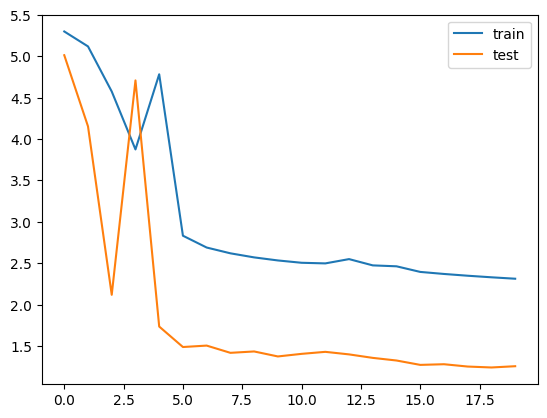

In [41]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [42]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

In [43]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# attention inference
# attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
# decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + [state_h2, state_c2])

In [44]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [45]:
def seq2summary(input_seq):
    '''
    convert an integer sequence to a word sequence for summary
    '''
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    '''
    convert an integer sequence to a word sequence for reviews
    '''
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [48]:
for i in range(len(x_val)):
    print("Review:", seq2text(x_val[i]))
    print("Original summary:", seq2summary(y_val[i]))
    print("Predicted summary:", decode_sequence(x_val[i].reshape(1, max_len_text)))
    print("\n")

Review: candy red flavor chewy would never buy 
Original summary: no flavor 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted summary:  great


Review: mix vet recommended limited ingredient food really helped symptoms likes always buy amazon cheaper free shipping 
Original summary: great for stomach 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted summary:  great


Review: around nuts case cut tiny powdered sugar tiny chewy highly recommend yummy treat familiar treat selling 
Original summary: it 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted summary:  great


Review: deal awesome arrived halloween enough love quality product much less expensive local store candy 
Original summary: deal 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70

In [52]:
for i in range(20, 50):
  print("Review:", seq2text(x_val[i]))
  print("Original summary:", seq2summary(y_val[i]))
  print("Predicted summary:", decode_sequence(x_val[i].reshape(1, max_len_text)))
  print("\n")

IndexError: index 20 is out of bounds for axis 0 with size 10